In [1]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# ================= CONFIGURATION =================
root_dir = Path("archive/ISLES-2022/ISLES-2022/")
derivatives_dir = root_dir / "derivatives"
csv_path = "train_chu.csv"

# Nouveaux dossiers pour ne pas écraser les anciens
output_img_dir = "IMAGE_3D_SEQ"
output_mask_dir = "MASKS_3D_SEQ"
output_stats_dir = "./preprocessing_stats_3D_seq"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)
os.makedirs(output_stats_dir, exist_ok=True)

# Paramètres
MIN_LESION_PIXELS = 40
RESIZE_TO = (224, 224)

In [2]:
# ================= FONCTIONS UTILES =================
def robust_normalize(img):
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    p1, p99 = np.percentile(img, [1, 99])
    img_clipped = np.clip(img, p1, p99)
    if p99 - p1 > 1e-8:
        return ((img_clipped - p1) / (p99 - p1) * 255).astype(np.uint8)
    return np.zeros_like(img, dtype=np.uint8)

def create_rgb_image(dwi_slice, adc_slice):
    dwi_norm = robust_normalize(dwi_slice)
    adc_norm = robust_normalize(adc_slice)
    return np.stack([dwi_norm, adc_norm, dwi_norm], axis=-1)

def save_image_mask(dwi, adc, gt, filename):
    rgb = create_rgb_image(dwi, adc)
    rgb_resized = cv2.resize(rgb, RESIZE_TO, interpolation=cv2.INTER_LINEAR)
    mask = (gt > 0).astype(np.uint8) * 255
    mask_resized = cv2.resize(mask, RESIZE_TO, interpolation=cv2.INTER_NEAREST)
    
    cv2.imwrite(os.path.join(output_img_dir, filename), rgb_resized)
    cv2.imwrite(os.path.join(output_mask_dir, filename), mask_resized)

In [3]:
# ================= LOGIQUE DE SÉQUENCE =================
def process_volume_plane(dwi_vol, adc_vol, gt_vol, pat_id, plane_name):
    """
    Traite un volume complet pour un plan donné (Axial, Coronal, ou Sagittal).
    Identifie les séquences continues de lésions.
    """
    n_slices = dwi_vol.shape[2]
    
    # 1. Identifier quelles slices sont "positives" (ont une lésion)
    positive_indices = []
    for i in range(n_slices):
        # Rotation pour être dans le bon sens (sauf axial qui est souvent bon)
        # On ne fait pas la rotation ici pour l'analyse, mais juste avant la sauvegarde
        # Pour l'analyse de seuil, on regarde les données brutes
        
        # NOTE: Sur certains plans, la slice brute peut être très petite ou bizarre
        # On vérifie juste le compte de pixels > 0
        if np.sum(gt_vol[:, :, i] > 0) >= MIN_LESION_PIXELS:
            # On vérifie aussi la qualité (pas vide, pas bruit pur)
            if np.std(dwi_vol[:, :, i]) > 1e-3:
                positive_indices.append(i)
    
    if not positive_indices:
        return 0

    # 2. Grouper en séquences continues
    # ex: [4, 5, 6, 10, 11] -> [[4, 5, 6], [10, 11]]
    sequences = []
    if positive_indices:
        current_seq = [positive_indices[0]]
        for x in positive_indices[1:]:
            if x == current_seq[-1] + 1: # Si c'est la slice juste après
                current_seq.append(x)
            else: # Rupture de séquence
                sequences.append(current_seq)
                current_seq = [x]
        sequences.append(current_seq)
    
    # 3. Sauvegarder avec le nommage intelligent
    saved_count = 0
    
    for seq_id, seq in enumerate(sequences):
        for seq_pos, slice_idx in enumerate(seq):
            # Extraction et Rotation pour l'affichage
            # La rotation dépend du plan pour avoir une tête "droite"
            # Axial: souvent OK ou rot90
            # Coronal/Sagittal: souvent besoin de rot90
            
            d_slice = np.rot90(dwi_vol[:, :, slice_idx])
            a_slice = np.rot90(adc_vol[:, :, slice_idx])
            g_slice = np.rot90(gt_vol[:, :, slice_idx])
            
            # Nommage: ID_PLAN_SLICE_SEQID_SEQPOS.png
            # seq_id+1 pour commencer à 1
            filename = f"{pat_id}_{plane_name}_{slice_idx:03d}_seq{seq_id+1:02d}_{seq_pos:02d}.png"
            
            save_image_mask(d_slice, a_slice, g_slice, filename)
            saved_count += 1
            
    return saved_count


In [4]:
# ================= PRÉPARATION DES DONNÉES =================
data_list = []
if root_dir.exists() and derivatives_dir.exists():
    print("🔍 Mode ISLES détecté")
    subjects = sorted([d for d in root_dir.iterdir() if d.is_dir() and d.name.startswith("sub-strokecase")])
    for subj_path in tqdm(subjects, desc="Indexation"):
        subj_name = subj_path.name
        for ses_path in [s for s in subj_path.iterdir() if s.is_dir() and s.name.startswith("ses-")]:
            dwi_folder = ses_path / "dwi"
            if not dwi_folder.exists(): continue
            raw_files = list(dwi_folder.rglob("*.nii")) + list(dwi_folder.rglob("*.nii.gz"))
            
            dwi_f, adc_f = None, None
            for f in raw_files:
                if "dwi" in f.name.lower() and "adc" not in f.name.lower() and not f.name.startswith('.'): dwi_f = f
                elif "adc" in f.name.lower() and not f.name.startswith('.'): adc_f = f
            
            mask_search = derivatives_dir / subj_name / ses_path.name
            mask_f = None
            if mask_search.exists():
                cands = [f for f in list(mask_search.rglob("*.nii")) + list(mask_search.rglob("*.nii.gz")) if not f.name.startswith('.')]
                if cands: mask_f = cands[0]

            if dwi_f and adc_f and mask_f:
                data_list.append({'sub_id': subj_name, 'dwi_col': str(dwi_f), 'adc_col': str(adc_f), 'gt_col': str(mask_f)})

elif os.path.exists(csv_path):
    print("🔍 Mode CHU détecté")
    data_list = pd.read_csv(csv_path).to_dict('records')

🔍 Mode ISLES détecté


Indexation: 100%|███████████████████████████| 250/250 [00:00<00:00, 3692.86it/s]


In [5]:
# ================= BOUCLE PRINCIPALE =================
stats = {
    'patients': 0,
    'total_saved': 0,
    'by_plane': {'axial': 0, 'coronal': 0, 'sagittal': 0},
    'errors': []
}

print(f"\n🚀 Démarrage: Extraction Multi-Vues avec Séquences...")

for item in tqdm(data_list, desc="Traitement"):
    try:
        # Chargement & Orientation Canonical (RAS)
        dwi_nii = nib.as_closest_canonical(nib.load(item['dwi_col']))
        adc_nii = nib.as_closest_canonical(nib.load(item['adc_col']))
        gt_nii = nib.as_closest_canonical(nib.load(item['gt_col']))
        
        d_data = dwi_nii.get_fdata()
        a_data = adc_nii.get_fdata()
        g_data = gt_nii.get_fdata()
        
        if not (d_data.shape == a_data.shape == g_data.shape):
            continue
            
        pat_id = item.get('sub_id', 'unknown')
        stats['patients'] += 1
        
        # 1. AXIAL (Z est le dernier axe)
        count = process_volume_plane(d_data, a_data, g_data, pat_id, "axial")
        stats['by_plane']['axial'] += count
        stats['total_saved'] += count
        
        # 2. CORONAL (Y devient Z par transpose)
        # Transpose (X, Y, Z) -> (X, Z, Y)
        # Le nouveau "Z" (profondeur) est l'ancien Y
        d_cor = d_data.transpose(0, 2, 1)
        a_cor = a_data.transpose(0, 2, 1)
        g_cor = g_data.transpose(0, 2, 1)
        count = process_volume_plane(d_cor, a_cor, g_cor, pat_id, "coronal")
        stats['by_plane']['coronal'] += count
        stats['total_saved'] += count

        # 3. SAGITTAL (X devient Z par transpose)
        # Transpose (X, Y, Z) -> (Y, Z, X)
        d_sag = d_data.transpose(1, 2, 0)
        a_sag = a_data.transpose(1, 2, 0)
        g_sag = g_data.transpose(1, 2, 0)
        count = process_volume_plane(d_sag, a_sag, g_sag, pat_id, "sagittal")
        stats['by_plane']['sagittal'] += count
        stats['total_saved'] += count

    except Exception as e:
        stats['errors'].append(f"{item.get('sub_id')}: {e}")


🚀 Démarrage: Extraction Multi-Vues avec Séquences...


Traitement: 100%|█████████████████████████████| 250/250 [00:33<00:00,  7.57it/s]



📊 RAPPORT SÉQUENCES
Total Images : 9176
Axial        : 2588
Coronal      : 3634
Sagittal     : 2954
Erreurs      : 0

Exemple: sub-strokecase0153_axial_002_seq01_02.png


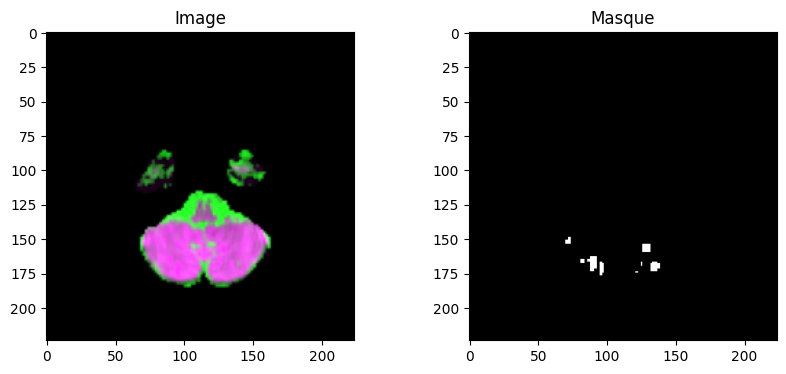

In [6]:
# ================= RAPPORT =================
print("\n" + "="*30)
print("📊 RAPPORT SÉQUENCES")
print("="*30)
print(f"Total Images : {stats['total_saved']}")
print(f"Axial        : {stats['by_plane']['axial']}")
print(f"Coronal      : {stats['by_plane']['coronal']}")
print(f"Sagittal     : {stats['by_plane']['sagittal']}")
print(f"Erreurs      : {len(stats['errors'])}")

# Exemple de vérification
import random
if os.listdir(output_img_dir):
    ex = random.choice(os.listdir(output_img_dir))
    print(f"\nExemple: {ex}")
    # Le nom contient l'info de séquence, ex: ..._seq01_02.png
    # Cela veut dire: 1ère séquence identifiée, 3ème image de la séquence
    
    img = cv2.imread(os.path.join(output_img_dir, ex))
    msk = cv2.imread(os.path.join(output_mask_dir, ex))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.title("Image")
    plt.subplot(1, 2, 2); plt.imshow(msk, cmap='gray'); plt.title("Masque")
    plt.show()